In [1]:
import tangos
import pynbody

import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.utils import data
from astropy.wcs import WCS

import matplotlib.pyplot as plt

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

import glob

# Population Figure

# Profiles

In [2]:
haloIDs = [431, 492]

In [3]:
def getfilepath(h):
    '''
    gets file path for data of halo h in [CDM, SIDM] order 
    '''
    
    cdm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25.3072g1HsbBH/r'+str(h)
    cdm += '.romulus25.3072g1HsbBH.004096'
    
    sidm = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r'+str(h)+'.romulus25cvdXsec.3072g1HsbBH/r'+str(h)
    sidm +='.romulus25cvdXsec.3072g1HsbBH.004096'
    
    return [cdm,sidm]

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


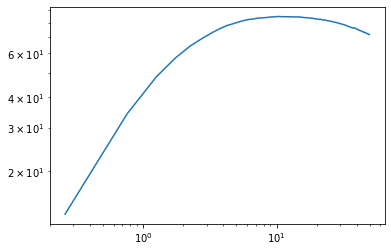

In [4]:
cdmFile = getfilepath(haloIDs[0])[0] + '/r'+str(haloIDs[0])+'.romulus25.3072g1HsbBH.004096'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()
hCDM = sCDM.halos()[1]

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

# profile range
pmin = 0.01
#pmax = pynbody.analysis.halo.virial_radius(h1) / 4
pmax = 4

p= pynbody.analysis.profile.Profile(hCDM.d, rmin='0.01 kpc', rmax='50 kpc', type='lin')
test = pynbody.analysis.profile.v_circ(p)
plt.plot(p['rbins'], test)

plt.xscale('log')
plt.yscale('log')

In [8]:
def fourPanelProfiles(hID, d=1):
    # get data paths for specified halo 
    cdmPath, sidmPath = getfilepath(hID)
    
    cdmFile = cdmPath + '/r'+str(hID)+'.romulus25.3072g1HsbBH.004096'
    sidmFile = sidmPath + '/r'+str(hID)+'.romulus25cvdXsec.3072g1HsbBH.004096'
    
    orientation = 0
    
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    plt.figure(facecolor='white')
    
    sCDM = pynbody.load(cdmFile)
    sSIDM = pynbody.load(sidmFile)
    
    sCDM.physical_units()
    sSIDM.physical_units()
    
    hCDM = sCDM.halos()[1]
    hSIDM = sSIDM.halos()[1]
    
    # center based on potential
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot
    cen_pot = pynbody.analysis.halo.center(hSIDM, mode='pot', retcen=True)
    sSIDM['pos'] -= cen_pot
    
    # profile range
    pmin = '0.01 kpc'
    #pmax = pynbody.analysis.halo.virial_radius(h1) / 4
    pmax = '50 kpc'
    
    # rotation curve
    pdCDM = pynbody.analysis.profile.Profile(hCDM.d, rmin=pmin, rmax=pmax, type='lin')
    pgCDM = pynbody.analysis.profile.Profile(hCDM.g, rmin=pmin, rmax=pmax, type='lin')
    psCDM = pynbody.analysis.profile.Profile(hCDM.s, rmin=pmin, rmax=pmax, type='lin')
    pCDM  = pynbody.analysis.profile.Profile(hCDM,   rmin=pmin, rmax=pmax, type='lin')
    
    pdSIDM = pynbody.analysis.profile.Profile(hSIDM.d, rmin=pmin, rmax=pmax, type='lin')
    pgSIDM = pynbody.analysis.profile.Profile(hSIDM.g, rmin=pmin, rmax=pmax, type='lin')
    psSIDM = pynbody.analysis.profile.Profile(hSIDM.s, rmin=pmin, rmax=pmax, type='lin')
    pSIDM  = pynbody.analysis.profile.Profile(hSIDM,   rmin=pmin, rmax=pmax, type='lin')
    
    pdCDM2 = pynbody.analysis.profile.v_circ(pdCDM)
    pdSIDM2 = pynbody.analysis.profile.v_circ(pdSIDM)
    
    cdmC = 'coral'
    sidmC = 'royalblue'
    lw = 3
    
    key = 'density'
    if d == 0:
        key = 'v_circ'
    axs[0,0].plot(pdCDM['rbins'], pdCDM[key], c=cdmC, linewidth=lw)
    axs[0,0].plot(pdSIDM['rbins'], pdSIDM[key], c=sidmC, linewidth=lw)
   # if d==0:
        #axs[0,0].plot(pdCDM['rbins'], pdCDM2, c='red', linestyle='--', linewidth=2)
        #axs[0,0].plot(pdSIDM['rbins'], pdSIDM2, c='blue', linestyle='--', linewidth=2)
    
    axs[0,1].plot(pgCDM['rbins'], pgCDM[key], c=cdmC, linewidth=lw)
    axs[0,1].plot(pgSIDM['rbins'], pgSIDM[key], c=sidmC, linewidth=lw)
    
    axs[1,0].plot(psCDM['rbins'], psCDM[key], c=cdmC, linewidth=lw)
    axs[1,0].plot(psSIDM['rbins'], psSIDM[key], c=sidmC, linewidth=lw)
    
    axs[1,1].plot(pCDM['rbins'], pCDM[key], c=cdmC, linewidth=lw)
    axs[1,1].plot(pSIDM['rbins'], pSIDM[key], c=sidmC, linewidth=lw)
    
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    
    plt.suptitle('Density Profiles for Galaxy '+str(hID), fontsize=20)
    if d == 0: plt.suptitle('Rotation Profiles for Galaxy '+str(hID), fontsize=20)
        
    axs[0,0].set_title('Dark Matter', fontsize=16)
    axs[0,1].set_title('Gas', fontsize=16)
    axs[1,0].set_title('Stars', fontsize=16)
    axs[1,1].set_title('All', fontsize=16)
    
    axs[0,0].legend(['CDM', 'SIDM'])
    
    plt.tight_layout()

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this 

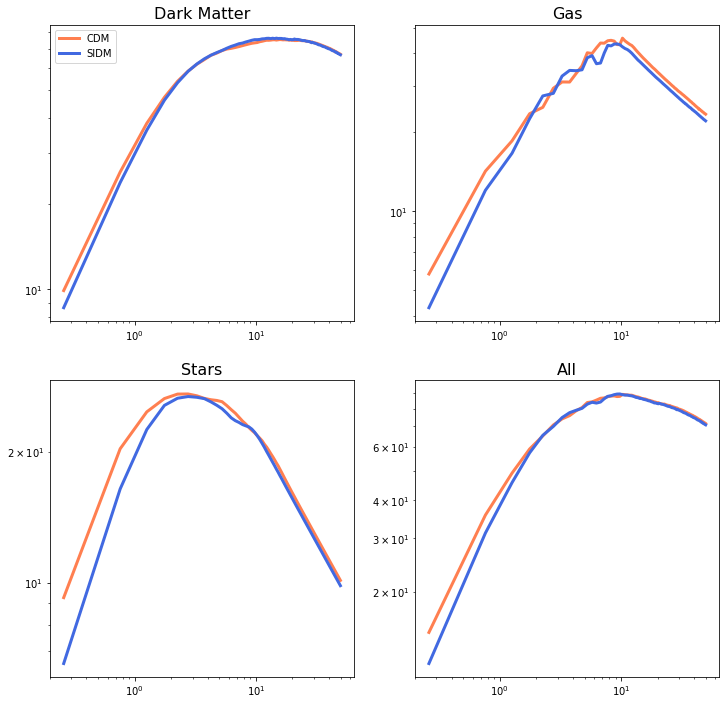

<Figure size 432x288 with 0 Axes>

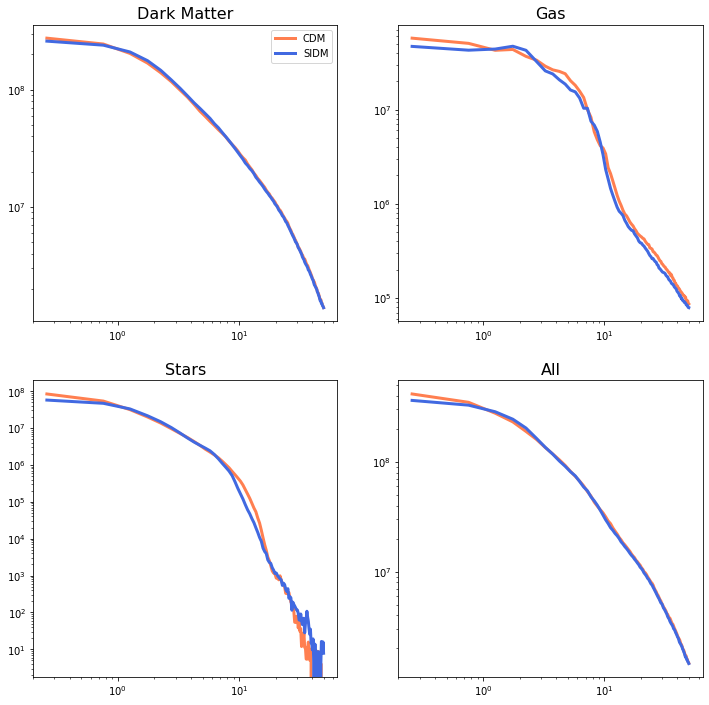

<Figure size 432x288 with 0 Axes>

In [9]:
hidx = 1

fourPanelProfiles(haloIDs[hidx], d=0)
plt.savefig('../figures/RotProfiles/r'+str(haloIDs[hidx])+'_rotation.png')

fourPanelProfiles(haloIDs[hidx], d=1)
plt.savefig('../figures/DenProfiles/r'+str(haloIDs[hidx])+'_density.png')

# H1

In [175]:
fpath = getfilepath(431)

In [186]:
h1files = glob.glob(fpath[1]+'/*.fits')
h1files.sort()

In [187]:
# 36 x 54 x 54
data = fits.open(h1files[0])[0].data

In [188]:
h1files

['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.x.fits',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.y.fits',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25cvdXsec.3072g1HsbBH/r431.romulus25cvdXsec.3072g1HsbBH.004096/r431.alfalfa_hi.z.fits']

In [189]:
fits.open(h1files[0])[0].header

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                   54 /                                                
NAXIS2  =                   54 /                                                
NAXIS3  =                   36 /                                                
CTYPE1  = 'KPC-LIN'            /                                                
CUNIT1  = 'KPC'                /                                                
CRVAL1  =          -100.000005 /                                                
CDELT1  =             3.703704 /                                                
CRPIX1  =                  1.0 /                                                
CTYPE2  = 'KPC-LIN'            /                                                
CUNIT2  = 'KPC'             

In [190]:
# function to perform integration 
def integrateSpectral(data, initSpd, deltaSpd):
    start = 0
    end = len(data)

    tot = []
    for i in range(start,end):
        d = np.nan_to_num(np.array(data[i,:,:]), True, nan=0.0)
        d = d.flatten()
        tot.append(sum(d))

    vmax = max(tot)

    # make x-axis for line width figure 
    x = []
    for i in range(len(data)):
        x.append(initSpd+i*deltaSpd)
        
    return x, tot

In [191]:
# integrating over spectral axis
start = 0
end = len(data)

tot = []
for i in range(start,end):
    d = np.nan_to_num(np.array(data[i,:,:]), True, nan=0.0)
    d = d.flatten()
    tot.append(sum(d))
    
vmax = max(tot)

# make x-axis for line width figure 
st = -194.4
d = 11.2
x = []
for i in range(len(data)):
    x.append(st+i*d)

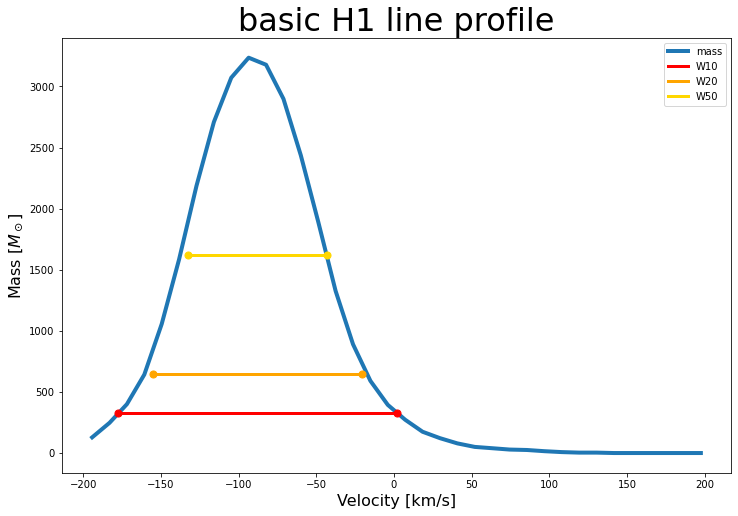

In [192]:
plt.figure(figsize=(12,8))

plt.plot(x,tot, linewidth=4)

plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Mass [$M_\odot$]', fontsize=16)
plt.title('basic H1 line profile', fontsize=32)

intervals = [10, 20, 50]
c = ['red', 'orange', 'gold']
for i,p in enumerate(intervals):
    val = (p/100)*vmax
    
    idxs_mass = np.argwhere(np.diff(np.sign(tot - np.full(len(tot),val)))).flatten()
    x1 = (x[idxs_mass[0]]+x[idxs_mass[0]+1])/2
    x2 = (x[idxs_mass[1]]+x[idxs_mass[1]+1])/2
    
    plt.plot([x1,x2],[val,val], linewidth=3, c=c[i], zorder=2)
    plt.scatter([x1,x2],[val,val], c=c[i], s=50, label='_nolegend_', zorder=2)
    
plt.legend(['mass', 'W10', 'W20', 'W50'])

1.4154592

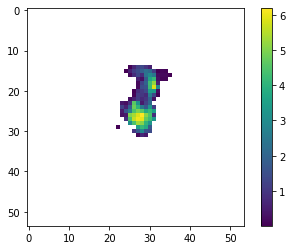

In [193]:
plt.imshow(data[18,:,:])
plt.colorbar()
data[18,30,30]

In [194]:
data.flatten()[18*30*30]

nan

In [200]:
d2 = np.nan_to_num(data) * fits.open(h1files[0])[0].header['BSCALE'] + fits.open(h1files[0])[0].header['BZERO']
d3 = 10.0**d2
spectrum = np.sum(np.sum(d3, 1), 1)

In [201]:
d3[18,30,30]

31201.84

In [202]:
np.where(d3 == 10**(fits.open(h1files[0])[0].header['BLANK'] * fits.open(h1files[0])[0].header['BSCALE'] + fits.open(h1files[0])[0].header['BZERO']))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [203]:
len(spectrum)

36

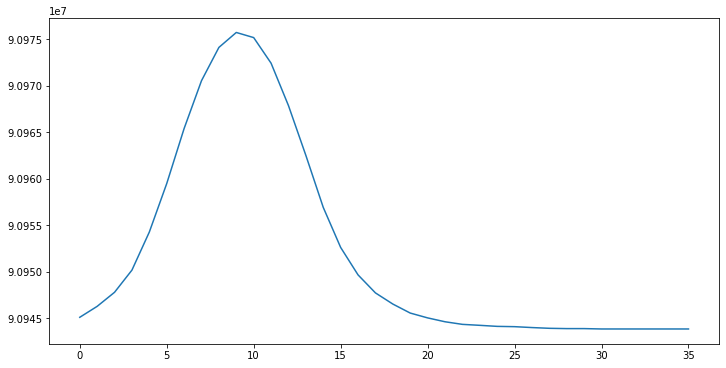

In [204]:
plt.figure(figsize=(12,6))
plt.plot(spectrum)

## Four panel, comparing different angles of CDM to SIDM

In [26]:
# function to make figure 
def fourPanelH1_likeAngles(hID):
    # some plotting params 
    intervals = [10, 20, 50]
    cdmC = 'coral'
    sidmC = 'royalblue'
    cdmWs = ['orangered', 'orangered', 'orangered']
    sidmWs = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue']
    lw=3
    lwW = 1.5
    ms = 35
    
    # get data paths for specified halo 
    cdmPath, sidmPath = getfilepath(hID)
    
    cdmFiles = glob.glob(cdmPath+'/*.fits')
    cdmFiles.sort()
    if len(cdmFiles) == 4: cdmFiles = cdmFiles[1:]
    sidmFiles = glob.glob(sidmPath+'/*.fits')
    sidmFiles.sort()
    
    fig, axs = plt.subplots(3,1, figsize=(10, 14))
    
    # iterate over orientations 
    for i in range(len(sidmFiles)):
        # load data for each file
        cdmf = fits.open(cdmFiles[i])[0]
        cdmInitSpd = cdmf.header['CRVAL3']
        cdmDeltaSpd = cdmf.header['CDELT3']
        cdmDat = cdmf.data
        
        sidmf = fits.open(sidmFiles[i])[0]
        sidmInitSpd = sidmf.header['CRVAL3']
        sidmDeltaSpd = sidmf.header['CDELT3']
        sidmDat = sidmf.data
        
        # integrate
        cdmX, cdmY = integrateSpectral(cdmDat, cdmInitSpd, cdmDeltaSpd)
        sidmX, sidmY = integrateSpectral(sidmDat, sidmInitSpd, sidmDeltaSpd)
        
        # plot curves 
        lcdm, = axs[i].plot(cdmX, cdmY, linewidth=lw, c=cdmC)
        lsidm, = axs[i].plot(sidmX, sidmY, linewidth=lw, c=sidmC)
        
        # do line widths of cmd 
        vmax = max(cdmY)
        for j,p in enumerate(intervals):
            val = (p/100)*vmax

            idxs_mass = np.argwhere(np.diff(np.sign(cdmY - np.full(len(cdmY),val)))).flatten()
            if len(idxs_mass) < 2: continue 
            x1 = (cdmX[idxs_mass[0]]+cdmX[idxs_mass[0]+1])/2
            x2 = (cdmX[idxs_mass[1]]+cdmX[idxs_mass[1]+1])/2
            
            axs[i].plot([x1,x2],[val,val], linewidth=lwW, color=cdmWs[j], zorder=2)
            axs[i].scatter([x1,x2],[val,val], color=cdmWs[j], s=25, label='_nolegend_', zorder=2)
        
        # do line widths of sidm 
        vmax = max(sidmY)
        for j,p in enumerate(intervals):
            val = (p/100)*vmax

            idxs_mass = np.argwhere(np.diff(np.sign(sidmY - np.full(len(sidmY),val)))).flatten()
            if len(idxs_mass) < 2: continue 
            x1 = (sidmX[idxs_mass[0]]+sidmX[idxs_mass[0]+1])/2
            x2 = (sidmX[idxs_mass[1]]+sidmX[idxs_mass[1]+1])/2
            
            axs[i].plot([x1,x2],[val,val], linewidth=lwW, color=sidmWs[j], zorder=2)
            axs[i].scatter([x1,x2],[val,val], color=sidmWs[j], s=25, label='_nolegend_', zorder=2, marker='^')
        
        # prettify 
        titles = [r'$\hat{x}$ Orientation', r'$\hat{y}$ Orientation', r'$\hat{z}$ Orientation']
        axs[i].set_title(titles[i], fontsize=20)
        
        axs[i].set_xlabel('Velocity [km/s]', fontsize=14)
        axs[i].set_ylabel(r'$M_\odot$', fontsize=18)
        
        axs[i].legend([lcdm, lsidm],['CDM','SIDM'])

    plt.tight_layout()

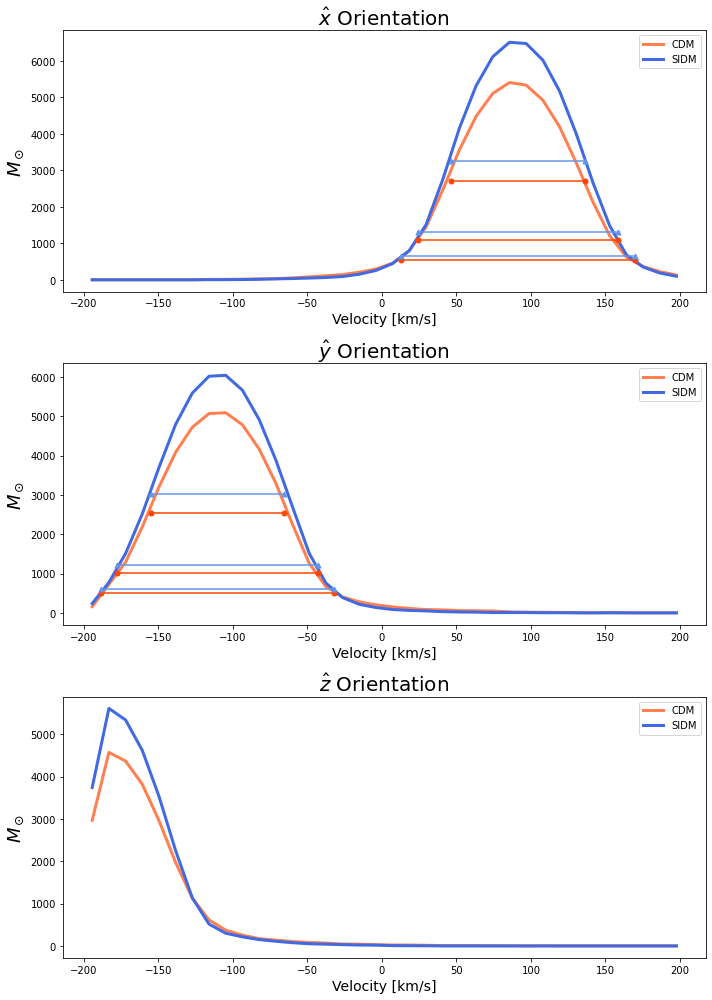

In [28]:
hidx = 1
fourPanelH1_likeAngles(haloIDs[hidx])
plt.savefig('figures/r'+str(haloIDs[hidx])+'_H1velocity.png')